# Code for the paper ''Cellular and environmental dynamics influence species-specific extents of organelle gene retention'' 

# by Belén García Pascual, University of Bergen, Norway

First we import the libraries that we need:

In [1]:
import numpy as np
from scipy.integrate import simps
from scipy.integrate import odeint
import pandas as pd
from mpmath import mp
import random
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
import bisect

# Implementation of the mathematical model of ODEs

Here we implement the ODEs

$\left\lbrace\begin{array}{l} \frac{dx_m}{dt}=(1-\alpha)\lambda p f(E,x_m) +D x_c- \nu_m x_m \\ \frac{dx_c}{dt}=\alpha \lambda f(E,x_m) - Dx_c-\nu_cx_c\end{array}\right.$

where $\alpha=0$ if the gene is in the organelle and $\alpha=1$ if the gene is in the nucleus, and

$f(E(t),x_m(t))=\left\lbrace\begin{array}{l} E(t)-x_m(t) \quad \text{if } x_m(t)\leq E(t) \\ 0 \quad \quad \quad \quad \quad \thinspace \thinspace \text{if } x_m(t)> E(t). \end{array}\right.$ 

- (1) For $E(t)=E_p(t)$ so that $E_p(t)=a\left(1+b\thinspace\text{sin} \left(\frac{2\pi k t}{\tau}\right)\right)$ with $\tau=144$, the parameters of the model are written as $param=[\lambda, D, \nu_m, \nu_c, p, a, b, k]$.

In [2]:
#function E_p(t)
def demand_function(t,a,b,k):
    d=a*(1+b*mp.sin(2*np.pi*k*t/144))
    return d

#model of ODEs, z=[x_m, x_c]
def model_Ep(z,t, alpha, param): 
    m=max(demand_function(t, param[5], param[6], param[7])-z[0], 0)
    dx_mdt = (1-alpha)*param[0]*m*param[4] + param[1]*z[1]-param[2]*z[0]
    dx_cdt = alpha*param[0]*m-param[1]*z[1]-param[3]*z[1]
    dzdt = [dx_mdt, dx_cdt]
    return dzdt

The cost $c_{\alpha}(t_i, t_f)=\int^{t_f}_{t_i} \mid E_p(t)-x_m(t)\mid dt$

over the time window $t_i=144, t_f=2\times 144$ is:

In [3]:
def cost_Ep(xm, t, param): 
        tl=t.tolist() #convert the array t into a list
        index_t= bisect.bisect(tl,144)-1 #find index of the time point 144 in t, add -1 to round down and get the exact position if 144 is in tl
        #find how many elements in the list tl we must integrate over
        t_step=t[1]-t[0]
        integral_steps = int(round(144/t_step)) #these are the number of points to intregrate over 
        #find sublist in tl from the position of 144 to the end
        tl_sublist=tl[-(integral_steps+1):] #count from the end the number of steps and return the sublist
        #compute the absolute difference between demand E and supply x_m for each time point in tl
        cost_list = [abs(demand_function(j, param[5], param[6], param[7])-xm[i]) for i,j in enumerate(tl)]
        #find analogous sublist to tl_sublist
        cost_sublist=cost_list[-(integral_steps+1):]
        #value of the integral of the samples in cos_sublist over sl_sublist
        I=simps(cost_sublist, tl_sublist, even='avg') #'avg' to average the results of two different methods used by the integrator
        return I

To plot the cost function defined above as a timeline for each time point $t$, we define the accumulated cost from $t_i=0$ to $t_f=t$ by:

In [4]:
def cost_at_t_Ep(xm, t, param):
    results=[] #add here the integral values from 0 to each time point
    tl_sublist=[] #add here the time points in t to integrate over
    c_sublist=[] #add here the absolute difference between demand E_p and supply x_m for each time point
    tl=t.tolist() #convert the array t into a list
    #calculate integral from 0 to the time point t for each t in tl
    for j, s in enumerate(tl):
        tl_sublist.append(s)
        c_sublist.append(abs(demand_function(s, param[5], param[6], param[7])-xm[j]))
        I=simps(c_sublist, tl_sublist, even='avg')
        results.append(I)
    return results

- (2) The time-averaged demand $a$ is set to be $a=1$ for both cases of random environments (2) and (3) defined below. For $E(t)=E_w(t)$ so that $E_w(t)\sim U(0,2)$ for each $t$, the parameters are $param=[\lambda, D, \nu_m, \nu_c, p]$.  The model is implemented by:

In [5]:
#since we generate random numbers U(0,2) following a uniform distribution in the interval [0,2],
#first we fix a seed, here it is 0, to get the same results every time we run the simulation
rng=np.random.RandomState(0)

#function E_w(t)
# is a list of random numbers between 0 and 2 uniformly distributed.
# the list has 5 times more numbers than numbers of time points, as the number of time points will be set to be 2*288
#like this, if the ODE solver varies its time step-size to make it smaller, there will be enough random numbers to pick from 
demand_white=rng.uniform(0,2,2*288*5)

#define a function to implement E_w(t) in the solver of the ODEs
#for each time point t, the solver gives a numerical solution of the ODEs, so we assignt to the ODEs the random number
#in 'demand' in the same position as that t.
def demand_for_t(demand,t): # the input 'demand' is either demand_white or demand_red defined below
    d=demand[int(t/step_size)]
    return  d

#model of ODEs for E_w(t)
def model_Ew(z, t, demand, alpha, param):
        m=max(demand_for_t(demand, t)-z[0], 0)
        dx_mdt = (1-alpha)*param[0]*m*param[4] + param[1]*z[1]-param[2]*z[0]
        dx_cdt = alpha*param[0]*m-param[1]*z[1]-param[3]*z[1]
        dzdt = [dx_mdt, dx_cdt]
        return dzdt


 And the cost function $c_{\alpha}(t_i, t_f)=\int^{t_f}_{t_i} \mid E_w(t)-x_m(t)\mid dt$ over the time window $t_i=144, t_f=2\times 144$ is defined analogously to the above case (1):

In [6]:
def cost_Ew(xm, demand, t, param): 
        tl=t.tolist()
        index_t= bisect.bisect(tl,144)-1
        t_step=t[1]-t[0]
        integral_steps = int(round(144/t_step))
        tl_sublist=tl[-(integral_steps+1):] 
        cost_list = [abs(demand[i]-xm[i]) for i,j in enumerate(tl)]
        cost_sublist=cost_list[-(integral_steps+1):]
        I=simps(cost_sublist, tl_sublist, even='avg')
        return I

To plot the cost function defined above as a timeline for each time point $t$, we define the accumulated cost from $t_i=0$ to $t_f=t$ as follows, which is analogous to the above case (1):

In [7]:
def cost_at_t_integrated_Ew(xm, demand, t, param):
    results=[]
    tl_sublist=[]
    c_sublist=[]
    tl=t.tolist()
    for j, s in enumerate(tl):
        tl_sublist.append(s)
        c_sublist.append(abs(demand[j]-xm[j]))
        I=simps(c_sublist, tl_sublist, even='avg')
        results.append(I)
    return results 

- (3) For $E(t)=E_r(t)$ so that $E_r(t)=\left\lbrace\begin{array}{l} E_r(0)\sim U(0,2) \quad \text{ for } t=0 \\ E_r(t-dt)+ \delta (t) \quad \text{for } \delta(t)\sim U(-0.05,0.05) \text{ and }
t>0\\\end{array}\right.$ 

with parameters $param=[\lambda, D, \nu_m, \nu_c, p]$, we implement the model by:

In [8]:
#E_r is defined by iterations
#first we define the list 'demand_red' for the random numbers
demand_red=[rng.uniform(0,2)] #the first element epsilon(0) is a random number between 0 and 2

for i in range(1,2*288*5,1): #recursion to define E_r, 2*288*5 is the range of the random numbers, 5 times more than the number of time points
    dt=demand_red[i-1]+rng.uniform(-0.05,0.05) #value at the next time point
    if dt>float(2.0):
        demand_red.append(2) #round to 2 if the value is over 2
    elif dt<float(0.0):
        demand_red.append(0) #round to zero if the value is below 0. E_r must be defined in the interval [0,2]
    else:
        demand_red.append(dt)

The implementation of the function $E_r(t)$ into the ODE solver so that it takes the random number in the same position as the time point it is solving the ODEs at, is analogous to the above case for $E_w(t)$. 
The model of ODEs and cost functions are also of the same form as for the white noise.

# Simulations

# Figure 2 in the paper. Heatmaps with the interplay of degradation and transport for static and noisy environments

- Static environment $E(t)=1$:

In [9]:
#Initial conditios x_m(0)=0 and x_c(0)=0
z0=[0,0]

#time interval [0, 2*144] with 2000 time points equally spaced in it
t=np.linspace(0,2*144,2000)

In [10]:
D=1 #change this value to 0.1 and 10 to get the other two heatmaps in Figure 2
p=0.75 #change to 0.9 and 1 for the figures in the SI

In [11]:
#parameter values for nu_m and nu_c 
nu_m_list=np.arange(0,1.1,0.1) #values from 0 to 1, both included, with a step size of 0.1
nu_c_list=np.arange(0,1.1,0.1)

In [12]:
diff_cost_ent=[] #add the difference between the cost for the nuclear-encoding and the organelle/mito-encoding
for index,nu_m in enumerate(nu_m_list):
    diff_cost_ent.append([])
    for nu_c in nu_c_list:
        param=[1,D,nu_m,nu_c,p, 1, 0, 0]
        sol_nucleus=odeint(model_Ep, z0, t, args=(1, param))
        sol_mito=odeint(model_Ep, z0, t, args=(0, param))
        cost_nucleus_ent=cost_Ep(sol_nucleus[:,0], t, param)
        cost_mito_ent=cost_Ep(sol_mito[:,0], t, param)
        diff_cost_ent[index].append(float(cost_nucleus_ent - cost_mito_ent))
        
#transform the cost differences into a data frame for each parameter value of nu_m and nu_c        
df_ent=pd.DataFrame(diff_cost_ent, index=nu_m_list, columns=nu_c_list, dtype=None, copy=None)

#Rearrange rows to display later the y-axis from lowest to highest values of nu_m
df_ent=df_ent.sort_index(axis=0, ascending=False)

#save the data frame as a CSV sheet for the given parameter value D=param[1] and p=param[4]
df_ent.to_csv('final_fig_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.csv', index=df_ent.index.tolist())

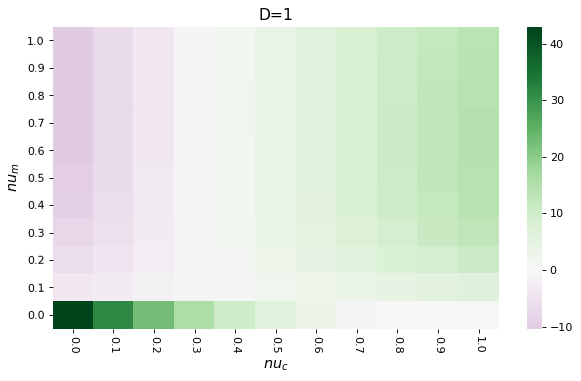

In [13]:
#open CSV file and transform to a data frame to plot the heatmap
#note to change the first part of the file location 'C:/Users/bpa013/' to your particular one where Jupyter saves the files
my_csv = Path('C:/Users/bpa013/final_fig_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.csv')
df_ent=pd.read_csv(my_csv, index_col=0)

#plot
fig = plt.figure(figsize = (9,5), dpi = 80)
ax = sns.heatmap(df_ent, cmap="PRGn", center=0.00, xticklabels=np.round(nu_c_list, decimals = 2), yticklabels=sorted(np.round(nu_m_list, decimals = 2), reverse=True))
ax.set_xlabel('$nu_c$', fontsize=13)
ax.set_ylabel('$nu_m$', fontsize=13)
plt.title('D='+str(param[1]), fontsize=14)
ax.tick_params(axis='x', labelrotation= -90)
ax.tick_params(axis='y',labelrotation= 1)

In [14]:
# we can automatically save the figure in a chosen file in our PC. Choose that file location as 'path'
# for example:
path=path='./'
fig.savefig(path+'heatmap_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.png',  bbox_inches='tight')

- Uncorrelated white noise:

In [15]:
#pick less time point for the noisy environments than for the static or fluctuating environments
#to make it easier for the ODE solver
t_noisy=np.linspace(0,2*144,2*288) 

#compute step size in t_noisy
step_size=2*144/2*288 

In [16]:
diff_cost_ent=[] #add the difference between the cost for the nuclear-encoding and the organelle/mito-encoding
for index,nu_m in enumerate(nu_m_list):
    diff_cost_ent.append([])
    for nu_c in nu_c_list:
        param=[1,D,nu_m,nu_c,p]
        sol_nucleus=odeint(model_Ew, z0, t_noisy, args=(demand_white, 1, param))
        sol_mito=odeint(model_Ew, z0, t_noisy, args=(demand_white, 0, param))
        cost_nucleus_ent=cost_Ew(sol_nucleus[:,0], demand_white, t_noisy, param)
        cost_mito_ent=cost_Ew(sol_mito[:,0], demand_white, t_noisy, param)
        diff_cost_ent[index].append(float(cost_nucleus_ent - cost_mito_ent))
        
#transform the cost differences into a data frame for each parameter value of nu_m and nu_c        
df_ent=pd.DataFrame(diff_cost_ent, index=nu_m_list, columns=nu_c_list, dtype=None, copy=None)

#Rearrange rows to display later the y-axis from lowest to highest values of nu_m
df_ent=df_ent.sort_index(axis=0, ascending=False)

#save the data frame as an CSV sheet for the given parameter value D=param[1] and p=param[4]
df_ent.to_csv('final_fig_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts_white_noise.csv', index=df_ent.index.tolist())

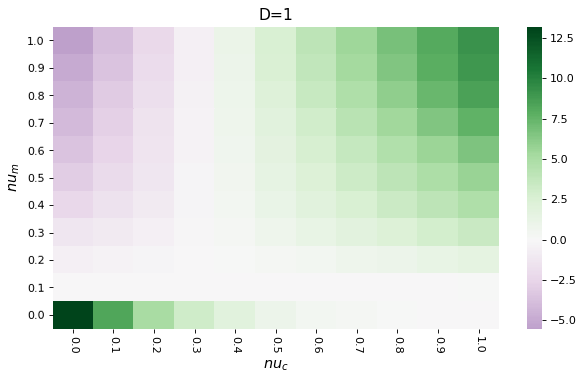

In [17]:
#rel costs
fig = plt.figure(figsize = (9,5), dpi = 80)
ax = sns.heatmap(df_ent, cmap="PRGn", center=0.00, xticklabels=np.round(df_ent.columns, decimals = 2), yticklabels=np.round(df_ent.index, decimals = 2)) 
ax.set_xlabel('$nu_c$', fontsize=13)
ax.set_ylabel('$nu_m$', fontsize=13)
plt.title('D='+str(param[1]), fontsize=14)
ax.tick_params(axis='x', labelrotation= -90)
ax.tick_params(axis='y',labelrotation= 1)

In [18]:
#save figure
fig.savefig(path+'heatmap_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts_white_noise.png',  bbox_inches='tight')

- Correlated red noise

In [19]:
diff_cost_ent=[] #add the difference between the cost for the nuclear-encoding and the organelle/mito-encoding
for index,nu_m in enumerate(nu_m_list):
    diff_cost_ent.append([])
    for nu_c in nu_c_list:
        param=[1,D,nu_m,nu_c,p]
        sol_nucleus=odeint(model_Ew, z0, t_noisy, args=(demand_red, 1, param))
        sol_mito=odeint(model_Ew, z0, t_noisy, args=(demand_red, 0, param))
        cost_nucleus_ent=cost_Ew(sol_nucleus[:,0], demand_red, t_noisy, param)
        cost_mito_ent=cost_Ew(sol_mito[:,0], demand_red, t_noisy, param)
        diff_cost_ent[index].append(float(cost_nucleus_ent - cost_mito_ent))
        
#transform the cost differences into a data frame for each parameter value of nu_m and nu_c        
df_ent=pd.DataFrame(diff_cost_ent, index=nu_m_list, columns=nu_c_list, dtype=None, copy=None)

#Rearrange rows to display later the y-axis from lowest to highest values of nu_m
df_ent=df_ent.sort_index(axis=0, ascending=False)

#save the data frame as an CSV sheet for the given parameter value D=param[1] and p=param[4]
df_ent.to_csv('final_fig_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts_red_noise.csv', index=df_ent.index.tolist())

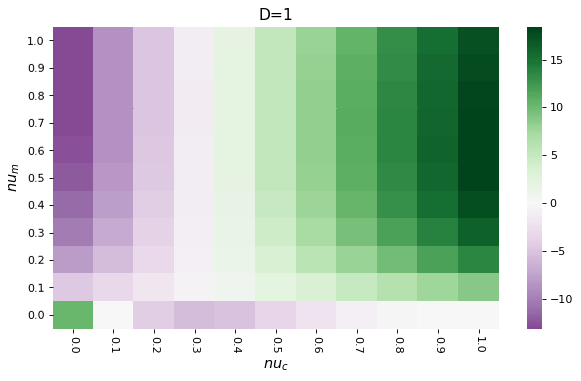

In [20]:
#rel costs
fig = plt.figure(figsize = (9,5), dpi = 80)
ax = sns.heatmap(df_ent, cmap="PRGn", center=0.00, xticklabels=np.round(df_ent.columns, decimals = 2), yticklabels=np.round(df_ent.index, decimals = 2)) 
ax.set_xlabel('$nu_c$', fontsize=13)
ax.set_ylabel('$nu_m$', fontsize=13)
plt.title('D='+str(param[1]), fontsize=14)
ax.tick_params(axis='x', labelrotation= -90)
ax.tick_params(axis='y',labelrotation= 1)

In [21]:
#save figure
fig.savefig(path+'heatmap_nu_m_vs_nu_c_p'+str(param[4])+'_d'+str(param[1])+'_relcosts_red_noise.png',  bbox_inches='tight')

# Figure 3 in the paper. Time-lines and phase planes in examples of noisy environments

In [22]:
# we need to pick every 5 points one point in demand to match the number of points in the solutions
# and be able to get phase planes
demand_white_every_5=[]
for i in range(0, len(demand_white), 5):
    demand_white_every_5.append(demand_white[i])
    
demand_red_every_5=[]
for i in range(0, len(demand_red), 5):
    demand_red_every_5.append(demand_red[i])
    
# we get the time points in [0, 2*144] corresponding to the number of points in demand to plot the demand as a time-line
t_demand=np.linspace(0,2*144,2*288*5)

In [23]:
# the environment is so noisy that it is difficult to see the traces in the plot, so we reduce the number of time points
t=np.linspace(0,2*144,2*288)
step_size=2*144/2*288

In [24]:
#pick white or red noise by setting demand=demand_white or demand=demand_red and analogous for demand_every_5
demand=demand_white
demand_every_5=demand_white_every_5

In [25]:
D=0.1 #change to D=1 for the other set of plots in Figure 3
param=[1,D,0.5,0, p] #(lambda, D, nu_m, nu_c, p)

#solutions
sol_nucleus=odeint(model_Ew, z0,  t, args=(demand,1, param))
sol_mito=odeint(model_Ew, z0, t, args=(demand, 0, param))

#costs
cost_nucleus=cost_at_t_integrated_Ew(sol_nucleus[:,0], demand, t, param)
cost_mito=cost_at_t_integrated_Ew(sol_mito[:,0], demand, t, param)

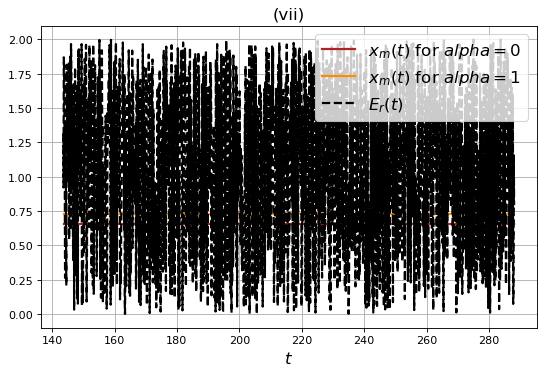

In [26]:
#prepare cut for the last day to plot time-lines
index_t=bisect.bisect(t,144)-1

#plots timelines x_m and Ew or Er for the last day [144, 2*144]
fig = plt.figure(figsize = (8,5), dpi = 80)
plt.plot(t[index_t: ], sol_mito[index_t:,0], color='firebrick',linewidth=2, label='$x_m(t)$ for $alpha=0$')
plt.plot(t[index_t: ], sol_nucleus[index_t:,0], color='darkorange',linewidth=2, label='$x_m(t)$ for $alpha=1$')
plt.plot(t_demand[index_t*5: ], demand[index_t*5: ], color='black', linestyle='dashed', linewidth=2, label='$E_r(t)$')
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.title('(vii)', fontsize=15) #change number for the different examples of white or red with D=1 or D=0.1
plt.show()

In [27]:
#save figure
#change manually the number viii for other examples of noisy environments
fig.savefig(path+'vii_timelines.png',  bbox_inches='tight')

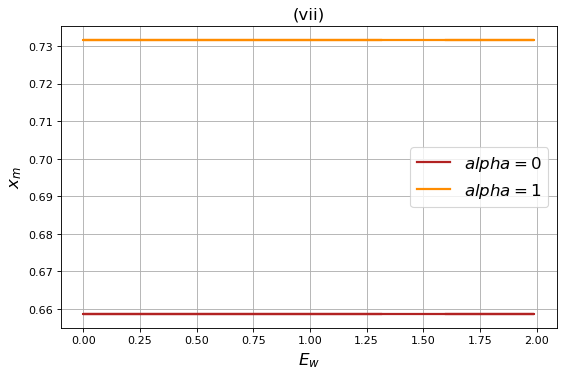

In [28]:
#plot phase planes

fig = plt.figure(figsize = (8,5), dpi = 80)
plt.plot(demand_every_5[index_t:], sol_mito[index_t:,0],color='firebrick',linewidth=2, label='$alpha=0$')
plt.plot(demand_every_5[index_t:], sol_nucleus[index_t:,0],color='darkorange',linewidth=2, label='$alpha=1$')
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('$E_w$', fontsize=15) #change to E_r if white noise is picked
plt.ylabel('$x_m$', fontsize=15)
plt.title('(vii)', fontsize=15) #change number for the different examples of white or red with D=1 or D=0.1
plt.show()

In [29]:
#save figure
#change manually the number viii for other examples of noisy environments
fig.savefig(path+'vii_phaseplanes.png',  bbox_inches='tight')

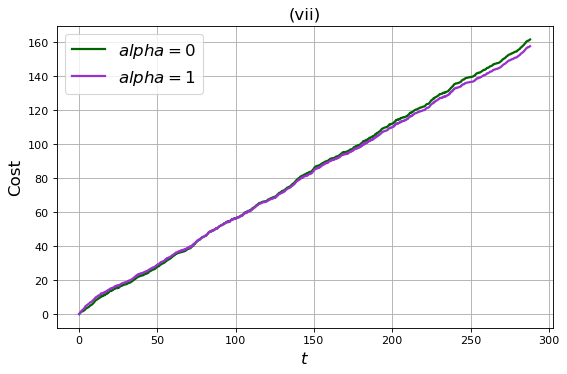

In [30]:
#plot costs as timelines
fig = plt.figure(figsize = (8,5), dpi = 80)
plt.plot(t, cost_mito, color='darkgreen',linewidth=2, label='$alpha=0$')
plt.plot(t, cost_nucleus, color='darkorchid',linewidth=2, label='$alpha=1$')
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('(vii)', fontsize=15) #change number for the different examples of white or red with D=1 or D=0.1
plt.show()

In [31]:
#save figure
#change manually the number viii for other examples of noisy environments
fig.savefig(path+'vii_costs.png',  bbox_inches='tight')

# Figure 4 in the paper. Heatmaps with the interplay of environmental oscillation and cell biological processes

- $a$ vs $k$ for either $b=0.5$ or $b=1$

In [32]:
b=0.5 #set this value as 0.5 or 1 for the different cases
D=0.1 #change this value to 0.01, 1 and 10 to get the other heatmaps in Figure 2 and in the Supplemental Information (SI)
p=0.75 #change to 0.9 and 1 for the figures in the SI

In [33]:
t=np.linspace(0,2*144,2000) #take a lot more time points that for the previous case of random environment
#prepare cut for the last day to plot time-lines
index_t=bisect.bisect(t,144)-1

In [34]:
a_list=np.arange(0.5,11.5,1)
k_list=np.arange(0,21,1)

diff_cost_ent=[]
for index,k in enumerate(k_list):
    diff_cost_ent.append([])
    for a in a_list:
        param=[1,D,0.5,0,p,a,b,k] #nu_m=0.5, nu_c=0
        sol_nucleus=odeint(model_Ep, z0, t, args=(1, param))
        sol_mito=odeint(model_Ep, z0, t, args=(0, param))
        cost_nucleus_ent=cost_Ep(sol_nucleus[:,0], t, param)
        cost_mito_ent=cost_Ep(sol_mito[:,0], t, param)
        diff_cost_ent[index].append(float(cost_nucleus_ent - cost_mito_ent))
        
df_ent=pd.DataFrame(diff_cost_ent, index=k_list, columns=a_list, dtype=None, copy=None)
df_ent=df_ent.sort_index(axis=0,ascending=False)
df_ent.to_csv('final_fig_a_vs_k_b'+str(param[6])+'_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.csv', index=df_ent.index.tolist())

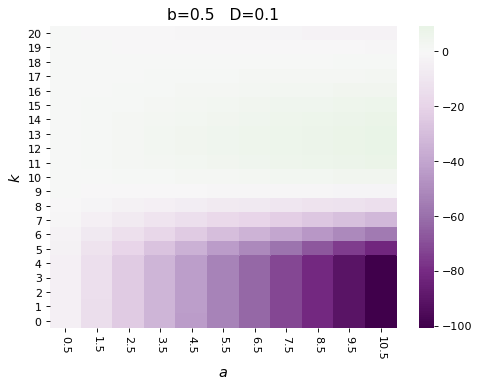

In [35]:
my_csv = Path('C:/Users/bpa013/final_fig_a_vs_k_b'+str(param[6])+'_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.csv')
df_ent=pd.read_csv(my_csv, index_col=0)

fig = plt.figure(figsize = (7,5), dpi = 80)
ax = sns.heatmap(df_ent, cmap="PRGn", center=0.00, xticklabels=np.round(a_list, decimals = 2), yticklabels=sorted(k_list, reverse=True)) #cbar_kws={"orientation": "horizontal"}
ax.set_xlabel('$a$', fontsize=13)
ax.set_ylabel('$k$', fontsize=13)
plt.title('b='+str(param[6])+'   D='+str(param[1]), fontsize=14)
ax.tick_params(axis='x', labelrotation= -90)
ax.tick_params(axis='y',labelrotation= 1)

In [36]:
#save figure
fig.savefig(path+'heatmap_a_vs_k_b'+str(param[6])+'_d'+str(param[1])+'_p'+str(param[4])+'relcosts.png',  bbox_inches='tight')

In some cases we set the same colour intervals for all the plots for the different values of $D$, this is done adding in sns.heatmap the arguments vmin for the minimal value and vmax for the maximum. This is the case in Figure 4, as displayed below for $a$ vs $k$:

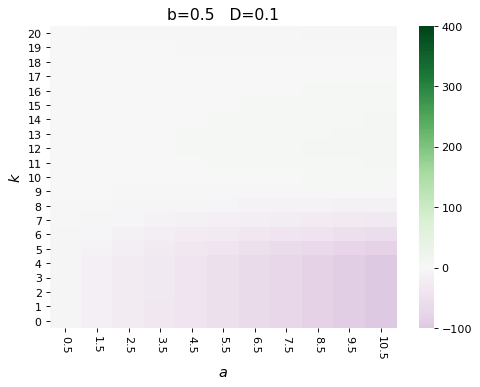

In [37]:
fig = plt.figure(figsize = (7,5), dpi = 80)
ax = sns.heatmap(df_ent, cmap="PRGn", center=0.00, vmin=-100, vmax=400, xticklabels=np.round(a_list, decimals = 2), yticklabels=sorted(k_list, reverse=True)) #cbar_kws={"orientation": "horizontal"}
ax.set_xlabel('$a$', fontsize=13)
ax.set_ylabel('$k$', fontsize=13)
plt.title('b='+str(param[6])+'   D='+str(param[1]), fontsize=14) #change b if b=1
ax.tick_params(axis='x', labelrotation= -90)
ax.tick_params(axis='y',labelrotation= 1)

- $b$ vs $k$ for $a=1$

In [38]:
k_list=np.arange(0,21,1) #values of the frequency k, from 0 to 20 spaced by 1
b_list=np.arange(0,1.05,0.05) #values of the relative amplitude b, from 0 to 1 spaced by 0.05

diff_cost_ent=[]
for index,k in enumerate(k_list):
    diff_cost_ent.append([])
    for b in b_list:
        param=[1,D,0.5,0,p,1,b,k] #nu_m=0.5, nu_c=0, a is fixed a=1
        sol_nucleus=odeint(model_Ep, z0, t, args=(1, param))
        sol_mito=odeint(model_Ep, z0, t, args=(0, param))
        cost_nucleus_ent=cost_Ep(sol_nucleus[:,0], t, param)
        cost_mito_ent=cost_Ep(sol_mito[:,0], t, param)
        diff_cost_ent[index].append(float(cost_nucleus_ent - cost_mito_ent))
#convert to a data frame      
df_ent=pd.DataFrame(diff_cost_ent, index=k_list, columns=b_list, dtype=None, copy=None)
#Rearrange rows in ascending order pandas python
df_ent=df_ent.sort_index(axis=0,ascending=False)
#save as a csv file
df_ent.to_csv('final_fig_b_vs_k_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.csv', index=df_ent.index.tolist())

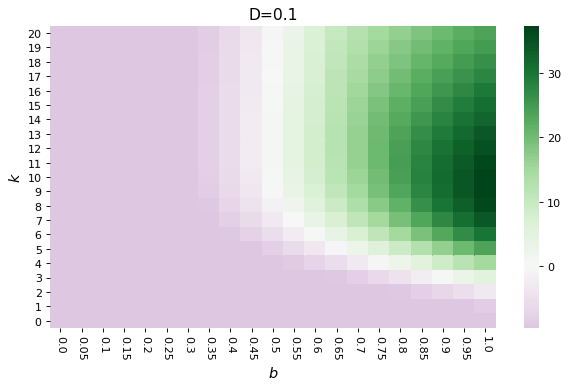

In [39]:
#plot heatmap
fig = plt.figure(figsize = (9,5), dpi = 80)
ax = sns.heatmap(df_ent, cmap="PRGn", center=0.00,xticklabels=np.round(b_list, decimals = 2), yticklabels=sorted(k_list, reverse=True))
ax.set_xlabel('$b$', fontsize=13)
ax.set_ylabel('$k$', fontsize=13)

plt.title('D='+str(param[1]), fontsize=14)
ax.tick_params(axis='x', labelrotation= -90)
ax.tick_params(axis='y',labelrotation= 1)

In [40]:
fig.savefig(path+'heatmap_bvsk_p'+str(param[4])+'_d'+str(param[1])+'_relcosts.png',  bbox_inches='tight')

# Figure 5 in the paper. Time behaviour and phase portraits of the system in different examples of periodically changing environments.

In [41]:
#we do case (ii)

D=0.1 #change to D=1 for case (iii)
k=4 #change for k=1 for case (i) or k=16 for case (iii)
param=[1,D,0.5,0,0.75, 1, 1, k] #(lambda=1, D=0.1, nu_m=0.5, nu_c=0, p=0.75, a=1, b=1, k=4), change parameter values for other cases

#solutions
sol_nucleus=odeint(model_Ep, z0, t, args=(1, param))
sol_mito=odeint(model_Ep, z0, t, args=(0, param))

#costs as time-lines
cost_nucleus=cost_at_t_Ep(sol_nucleus[:,0], t, param)
cost_mito=cost_at_t_Ep(sol_mito[:,0], t, param)

#compute the periodic environmental function E_p(t) for each time point t and add each value to the list sol_demand
#the list sol_demand is what we use to plot the function E_p(t) as a time-line
sol_demand=[]
for t_point in t:
    sd=demand_function(t_point, param[5], param[6], param[7])
    sol_demand.append(sd)

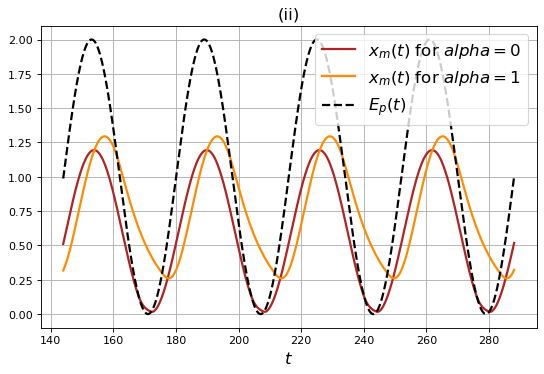

In [42]:
#plot timelines of x_m and E_p for the last day [144, 2*144]

fig = plt.figure(figsize = (8,5), dpi = 80)
plt.plot(t[index_t: ], sol_mito[index_t:,0], color='firebrick',linewidth=2, label='$x_m(t)$ for $alpha=0$')
plt.plot(t[index_t: ], sol_nucleus[index_t:,0], color='darkorange',linewidth=2, label='$x_m(t)$ for $alpha=1$')
plt.plot(t[index_t: ], sol_demand[index_t:], color='black', linestyle='dashed', linewidth=2, label='$E_p(t)$')
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.title('(ii)', fontsize=15)
plt.show()

In [43]:
#save figure
#change manually the number iii for other examples of fluctuating environments (i) or (iii)
fig.savefig(path+'ii_timelines.png',  bbox_inches='tight')

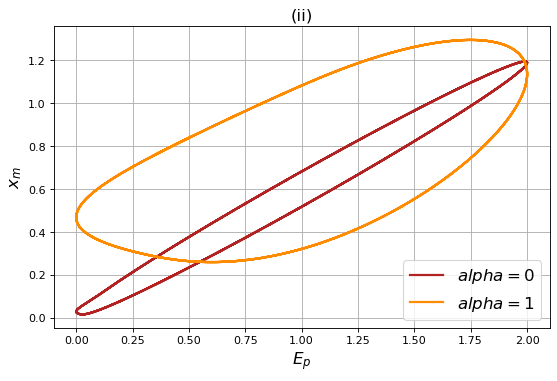

In [44]:
#plot phase planes
fig = plt.figure(figsize = (8,5), dpi = 80)
plt.plot(sol_demand[index_t:], sol_mito[index_t:,0],color='firebrick',linewidth=2, label='$alpha=0$')
plt.plot(sol_demand[index_t:], sol_nucleus[index_t:,0],color='darkorange',linewidth=2, label='$alpha=1$')
plt.grid()
plt.legend(loc='lower right', fontsize=15)
plt.xlabel('$E_p$', fontsize=15)
plt.ylabel('$x_m$', fontsize=15)
plt.title('(ii)', fontsize=15) #change number for other examples
plt.show()

In [45]:
#save figure
#change manually the number iii for other examples of fluctuating environments (i) or (iii)
fig.savefig(path+'ii_phaseplanes.png',  bbox_inches='tight')

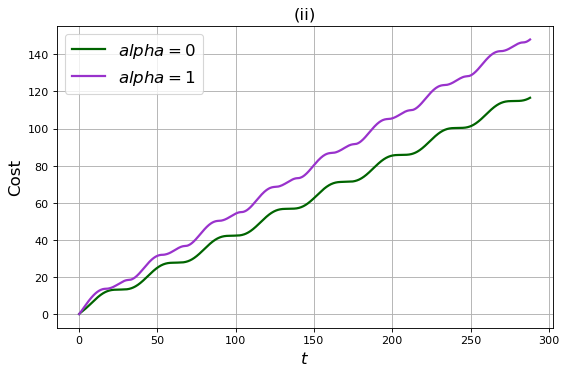

In [46]:
#plot costs as timelines
fig = plt.figure(figsize = (8,5), dpi = 80)
plt.plot(t, cost_mito, color='darkgreen',linewidth=2, label='$alpha=0$')
plt.plot(t, cost_nucleus, color='darkorchid',linewidth=2, label='$alpha=1$')
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('(ii)', fontsize=15) #change number for other examples
plt.show()

In [47]:
#save figure
#change manually the number iii for other examples of fluctuating environments (i) or (iii)
fig.savefig(path+'ii_costs.png',  bbox_inches='tight')